In [4]:
images_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\BrickStuds_Dataset\images"
labels_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\BrickStuds_Dataset\YOLO_txt_studs_labels"

# a function that takes a .txt labes folder and a image folder and checks if there are amatching files in both folders, and check if any of them are corrupted
# list all the conflicts and then ask the user to delete the corrupted pairs and not files with no matching pairs. also reporting the actuons taken
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
from pprint import pprint

def check_image_label_parity(images_folder, labels_folder):
    # get all the files in the images folder
    images_files = os.listdir(images_folder)
    labels_files = os.listdir(labels_folder)
    # get the image files without the extension
    images_files_no_ext = [os.path.splitext(file)[0] for file in images_files]
    labels_files_no_ext = [os.path.splitext(file)[0] for file in labels_files]
    # get the files that are in the images folder but not in the labels folder
    images_not_in_labels = [file for file in images_files_no_ext if file not in labels_files_no_ext]
    # get the files that are in the labels folder but not in the images folder
    labels_not_in_images = [file for file in labels_files_no_ext if file not in images_files_no_ext]
    # get the files that are in both folders

    files_in_both = [file for file in images_files_no_ext if file in labels_files_no_ext]

    if len(images_not_in_labels) == 0 and len(labels_not_in_images) == 0:
        print("All files are in both folders, checking for corrupted files")
    else:
        print("The following files are in the images folder but not in the labels folder")
        pprint(images_not_in_labels)
        print("The following files are in the labels folder but not in the images folder")
        pprint(labels_not_in_images)

        #delete files that are not in both folders
        for file in images_not_in_labels:
            print(f"deleting {file}.jpg")
            os.remove(os.path.join(images_folder, file + ".jpg"))
        for file in labels_not_in_images:
            print(f"deleting {file}.txt")
            os.remove(os.path.join(labels_folder, file + ".txt"))

        print("Files that are not in both folders have been deleted, checking for corrupted files...")

    # get the files that are in both folders but are corrupted
    corrupted_files = []
    for file in files_in_both:
        # check if the image is corrupted
        try:
            img = Image.open(os.path.join(images_folder, file + ".jpg"))
            img.verify()
        except Exception as e:
            print(f"{file}.jpg is corrupted")
            corrupted_files.append(file + ".jpg")
        # check if the label is corrupted
        try:
            with open(os.path.join(labels_folder, file + ".txt"), "r") as f:
                lines = f.readlines()
                for line in lines:
                    line = line.strip().split()
                    if len(line) != 5:
                        print(f"{file}.txt is corrupted")
                        corrupted_files.append(file + ".txt")
                        break
        except Exception as e:
            corrupted_files.append(file)

        if len(corrupted_files) == 0:
            print("No corrupted files found")
            return
        else:
            # delete the corrupted files
            for file in corrupted_files:
                print(f"deleting {file}")
                if file.endswith(".jpg"):
                    os.remove(os.path.join(images_folder, file))
                elif file.endswith(".txt"):
                    os.remove(os.path.join(labels_folder, file))
            print("Corrupted files have been deleted")
            return 

# check_image_label_parity(images_folder, labels_folder)

All files are in both folders, checking for corrupted files
No corrupted files found


In [25]:
import os
os.chdir("..")  # Ajusta según tu estructura


# Generate_folders_ImageDataProject.py

In [1]:
import os

def create_project_structure():
    """
    Create a folder structure for an image data project.

    The base path is automatically set to the current working directory.
    """
    # Set the base directory to the current working directory
    base_path = os.getcwd()

    # Define the folder structure
    structure = {
        "data": [
            "raw",
            "processed",
            "annotations"
        ],
        "src": [
            "data_preprocessing",
            "models",
            "visualization"
        ],
        "models": [
            "checkpoints",
            "final"
        ],
        "results": [
            "predictions",
            "logs"
        ],
        "docs": [],
        "notebooks": [],
        "tests": [],
        "presentation": []
    }

    # Function to create folders recursively
    def create_folders(base, folders):
        for folder, subfolders in folders.items():
            folder_path = os.path.join(base, folder)
            os.makedirs(folder_path, exist_ok=True)
            for subfolder in subfolders:
                os.makedirs(os.path.join(folder_path, subfolder), exist_ok=True)

    # Create the structure
    create_folders(base_path, structure)

    print(f"Project structure created successfully at: {base_path}")

# Example usage
if __name__ == "__main__":
    create_project_structure()


Project structure created successfully at: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision


# pipeline_setup.py

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import json
from pprint import pprint
import albumentations as A
import cv2
import yaml
import sys

# === Configuración Inicial ===
def detect_environment():
    """
    Detects the execution environment (Docker, Kaggle, Google Colab, or Local).

    Returns:
    - str: The detected environment name.
    """
    try:
        if os.path.exists("/.dockerenv"):  # Check for Docker
            return "docker"

        with open("/proc/self/cgroup", "r", encoding="utf-8", errors="ignore") as f:
            if any("docker" in line for line in f):
                return "docker"
    except FileNotFoundError:
        pass  # If the file doesn't exist, we are not in Docker

    if "google.colab" in sys.modules:  # Google Colab
        return "colab"

    if os.path.exists("/kaggle"):  # Kaggle
        return "kaggle"

    # Default to "local" (including Windows)
    return "local"

def setup_environment(dataset_name, base_path="/workspace/output"):
    """
    Configura el entorno según el sistema detectado y prepara el dataset.

    Parameters:
    - dataset_name (str): Nombre del dataset a descargar desde Kaggle.
    - base_path (str): Carpeta base donde se configurará la salida.

    Returns:
    - dict: Rutas configuradas para las imágenes y etiquetas crudas.
    """
    environment = detect_environment()
    print(f"\n[INFO] Entorno detectado: {environment.capitalize()}\n")

    dataset_mapping = {
        "studs": "labeledstuds-lego-bricks",
        "bricks": "spiled-lego-bricks"
    }

    if dataset_name not in dataset_mapping:
        raise ValueError(f"[ERROR] Dataset '{dataset_name}' no reconocido. Usa 'studs' o 'bricks'.")

    kaggle_dataset = dataset_mapping[dataset_name]

    if environment == "docker":
        dataset_path = "/workspace/datasets"
        os.makedirs(dataset_path, exist_ok=True)

        required_folders = ["images", "YOLO_ready_txt_labels"]
        for folder in required_folders:
            full_path = os.path.join(dataset_path, folder)
            if not os.path.exists(full_path):
                raise FileNotFoundError(f"[ERROR] Carpeta requerida no encontrada: {full_path}")
            print(f"[INFO] Carpeta verificada: {full_path}")

        return {
            "raw_images_path": os.path.join(dataset_path, "images"),
            "raw_labels_path": os.path.join(dataset_path, "YOLO_ready_txt_labels"),
            "output_path": base_path
        }

    elif environment == "kaggle":
        dataset_path = f"/kaggle/input/{kaggle_dataset}"
        required_folders = ["images", "YOLO_ready_txt_labels"]

        for folder in required_folders:
            full_path = os.path.join(dataset_path, folder)
            if not os.path.exists(full_path):
                raise FileNotFoundError(f"[ERROR] Carpeta requerida no encontrada: {full_path}")
            print(f"[INFO] Carpeta verificada: {full_path}")

        return {
            "raw_images_path": os.path.join(dataset_path, "images"),
            "raw_labels_path": os.path.join(dataset_path, "YOLO_ready_txt_labels"),
            "output_path": base_path
        }

    elif environment == "colab":
        from google.colab import userdata
        kaggle_path = "kaggle.json"
        if not os.path.exists(kaggle_path):
            os.makedirs("/root/.kaggle", exist_ok=True)

            kaggle_user = userdata.get('KaggleUser')
            kaggle_token = userdata.get('KaggleToken')
            if not kaggle_user or not kaggle_token:
                raise EnvironmentError("[ERROR] No se encontraron las credenciales de Kaggle en Google Colab.")

            kaggle_data = {"username": kaggle_user, "key": kaggle_token}
            with open("/root/.kaggle/kaggle.json", "w") as f:
                json.dump(kaggle_data, f)
                print("[INFO] Credenciales de Kaggle configuradas en Google Colab.")
        else:
            os.makedirs("/root/.kaggle", exist_ok=True)
            shutil.move(kaggle_path, "/root/.kaggle/kaggle.json")
            print("[INFO] Archivo kaggle.json movido a /root/.kaggle/")
        os.chmod("/root/.kaggle/kaggle.json", 0o600)
        os.makedirs("working", exist_ok=True)
        os.makedirs(f"working/{dataset_mapping[dataset_name]}", exist_ok=True)
        os.system(f"kaggle datasets download -d migueldilalla/{dataset_mapping[dataset_name]} -p working/{dataset_mapping[dataset_name]} --unzip")
        os.makedirs("working/output", exist_ok=True)
        dataset_path = f"working/{dataset_mapping[dataset_name]}"

        return {
            "raw_images_path": os.path.join(dataset_path, "images"),
            "raw_labels_path": os.path.join(dataset_path, "YOLO_ready_txt_labels"),
            "output_path": os.path.join(os.getcwd(), "working", "output")
        }

    elif environment == "local":
        kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
        if not os.path.exists(kaggle_json_path):
            raise EnvironmentError("[ERROR] Archivo kaggle.json no encontrado en ~/.kaggle/")
        os.makedirs("working", exist_ok=True)
        os.makedirs(f"working/{dataset_mapping[dataset_name]}", exist_ok=True)
        if not os.listdir(f"working/{dataset_mapping[dataset_name]}"):
            os.system(f"kaggle datasets download -d migueldilalla/{dataset_mapping[dataset_name]} -p working/{dataset_mapping[dataset_name]} --unzip")
        os.makedirs("working/output", exist_ok=True)
        dataset_path = f"working/{dataset_mapping[dataset_name]}"

        return {
            "raw_images_path": os.path.join(dataset_path, "images"),
            "raw_labels_path": os.path.join(dataset_path, "YOLO_ready_txt_labels"),
            "output_path": os.path.join(os.getcwd(), "working", "output")
        }

    else:
        raise EnvironmentError("[ERROR] No se pudo detectar el entorno correctamente.")


def setup_environment_custom(choice, base_path):
    """
    Configura el entorno manualmente basado en la elección del usuario.

    Parameters:
    - choice (str): 'k' para Kaggle, 'g' para Colab, 'l' para Local.
    - base_path (str): Ruta base para la salida.

    Returns:
    - dict: Rutas configuradas para las imágenes y etiquetas crudas.
    """
    if choice == "k":
        return setup_environment()
    elif choice == "g":
        return setup_environment(base_path="working")
    elif choice == "l":
        return setup_environment(base_path="working")
    else:
        raise EnvironmentError("[ERROR] Configuración desconocida.")

def verify_dataset_structure(raw_images_path, raw_labels_path):
    """
    Verifica la existencia de las carpetas requeridas en el dataset y muestra estadísticas iniciales.

    Parameters:
    - raw_images_path (str): Ruta a las imágenes crudas.
    - raw_labels_path (str): Ruta a las etiquetas crudas.
    """
    required_folders = [raw_images_path, raw_labels_path]
    summary = {}
    for folder in required_folders:
        if not os.path.exists(folder):
            raise FileNotFoundError(f"[ERROR] Carpeta requerida no encontrada: {folder}")

        num_files = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
        if num_files == 0:
            raise ValueError(f"[ERROR] La carpeta {folder} está vacía.")
        summary[folder] = num_files

    pprint({"Dataset Estructura": summary})

def create_preprocessing_structure(output_dir="/kaggle/working/output"):
    """
    Crea la estructura de carpetas para PREPROCESSING/.

    Parameters:
    - output_dir (str): Ruta base para la carpeta PREPROCESSING/.
    """
    os.makedirs(output_dir, exist_ok=True)
    subfolders = [
        "dataset/images/train", "dataset/images/val", "dataset/images/test",
        "dataset/labels/train", "dataset/labels/val", "dataset/labels/test",
        "test_images"
    ]
    for subfolder in subfolders:
        os.makedirs(os.path.join(output_dir, subfolder), exist_ok=True)
    print(f"[INFO] Estructura de carpetas creada en {output_dir}.")

def copy_and_partition_data(input_images, input_labels, output_dir):
    """
    Copia imágenes y etiquetas a las carpetas correspondientes y realiza la partición de datos.

    Parameters:
    - input_images (str): Carpeta de imágenes de entrada.
    - input_labels (str): Carpeta de etiquetas de entrada.
    - output_dir (str): Carpeta base para PREPROCESSING/.
    """
    images = sorted([f for f in os.listdir(input_images) if f.endswith(".jpg")])
    labels = sorted([f for f in os.listdir(input_labels) if f.endswith(".txt")])

    if len(images) != len(labels):
        raise ValueError("[ERROR] Número de imágenes y etiquetas no coincide.")

    image_paths = [os.path.join(input_images, img) for img in images]
    label_paths = [os.path.join(input_labels, lbl) for lbl in labels]

    train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(image_paths, label_paths, test_size=0.3, random_state=42)
    val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(temp_imgs, temp_lbls, test_size=0.33, random_state=42)

    partitions = {
        "train": (train_imgs, train_lbls),
        "val": (val_imgs, val_lbls),
        "test": (test_imgs, test_lbls)
    }

    for partition, (imgs, lbls) in partitions.items():
        for img, lbl in zip(imgs, lbls):
            shutil.copy(img, os.path.join(output_dir, f"dataset/images/{partition}/"))
            shutil.copy(lbl, os.path.join(output_dir, f"dataset/labels/{partition}/"))

    pprint({"Partición Completada": {partition: len(imgs) for partition, (imgs, _) in partitions.items()}})

def augment_data(input_images, input_labels, output_dir, num_augmentations=2):
    """
    Aplica aumentaciones al dataset y guarda imágenes y etiquetas aumentadas.

    Parameters:
    - input_images (str): Carpeta de imágenes originales.
    - input_labels (str): Carpeta de etiquetas en formato YOLO.
    - output_dir (str): Carpeta donde se guardarán los datos aumentados.
    - num_augmentations (int): Número de versiones aumentadas por imagen.
    """
    aug_images_dir = os.path.join(output_dir, "augmented_images")
    aug_labels_dir = os.path.join(output_dir, "augmented_labels")
    os.makedirs(aug_images_dir, exist_ok=True)
    os.makedirs(aug_labels_dir, exist_ok=True)

    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(height=640, width=640),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    images = sorted([f for f in os.listdir(input_images) if f.endswith(".jpg")])
    for img_file in images:
        img_path = os.path.join(input_images, img_file)
        label_path = os.path.join(input_labels, img_file.replace(".jpg", ".txt"))

        if not os.path.exists(label_path):
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"[WARNING] Skipping corrupted image: {img_path}")
            continue  # Skip this image and move to the next
        
        bboxes, class_labels = load_labels(label_path)

        for i in range(num_augmentations):
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_image = augmented["image"]
            aug_bboxes = augmented["bboxes"]
            aug_labels = augmented["class_labels"]

            aug_image_path = os.path.join(aug_images_dir, f"{img_file.split('.')[0]}_aug{i}.jpg")
            cv2.imwrite(aug_image_path, aug_image)

            aug_label_path = os.path.join(aug_labels_dir, f"{img_file.split('.')[0]}_aug{i}.txt")
            save_labels(aug_label_path, aug_bboxes, aug_labels)

    print(f"[INFO] Augmented data saved to {output_dir}.")

def load_labels(label_path):
    """
    Carga etiquetas en formato YOLO desde un archivo .txt.

    Parameters:
    - label_path (str): Ruta al archivo de etiquetas en formato YOLO.

    Returns:
    - bboxes (list): Lista de bounding boxes en formato YOLO.
    - class_labels (list): Lista de etiquetas de clase.
    """
    bboxes, class_labels = [], []
    with open(label_path, "r") as f:
        lines = f.readlines()
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        bboxes.append([x_center, y_center, width, height])
        class_labels.append(int(class_id))
    return bboxes, class_labels

def save_labels(output_path, bboxes, class_labels):
    """
    Guarda etiquetas en formato YOLO en un archivo .txt.

    Parameters:
    - output_path (str): Ruta donde se guardará el archivo de etiquetas.
    - bboxes (list): Lista de bounding boxes en formato YOLO.
    - class_labels (list): Lista de etiquetas de clase.
    """
    with open(output_path, "w") as f:
        for bbox, label in zip(bboxes, class_labels):
            f.write(f"{label} {' '.join(map(str, bbox))}\n")


def copy_augmented_to_train(augmented_dir, output_path):
    """
    Copia los datos aumentados a las subcarpetas correspondientes de 'train'.

    Parameters:
    - augmented_dir (str): Directorio que contiene imágenes y etiquetas aumentadas.
    - output_path(str): Ruta base para la salida.
    """
    aug_images_dir = os.path.join(augmented_dir, "augmented_images")
    aug_labels_dir = os.path.join(augmented_dir, "augmented_labels")
    train_images_dir = os.path.join(output_path, "dataset/images/train")
    train_labels_dir = os.path.join(output_path, "dataset/labels/train")

    for img_file in os.listdir(aug_images_dir):
        shutil.copy(os.path.join(aug_images_dir, img_file), train_images_dir)

    for label_file in os.listdir(aug_labels_dir):
        shutil.copy(os.path.join(aug_labels_dir, label_file), train_labels_dir)

    print(f"[INFO] Augmented data merged into train set at {output_path}.")

def create_dataset_yaml(output_path, num_classes, class_names):
    """
    Creates a dataset.yaml file with absolute paths for YOLO training.

    Parameters:
    - output_path (str): Base directory where the dataset.yaml file will be saved.
    - num_classes (int): Total number of classes.
    - class_names (list): List of class names.
    """
    # Resolve absolute paths for train and val folders
    dataset_dir = os.path.abspath(output_path)
    train_path = os.path.join(dataset_dir, "images/train")
    val_path = os.path.join(dataset_dir, "images/val")

    # Create the dataset configuration dictionary
    dataset_config = {
        "path": dataset_dir,
        "train": train_path,
        "val": val_path,
        "nc": num_classes,
        "names": {i: name for i, name in enumerate(class_names)}
    }

    # Save the configuration to the dataset.yaml file
    yaml_path = os.path.join(dataset_dir, "dataset.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"[INFO] dataset.yaml created at: {yaml_path}")

def validate_final_structure(output_dir="/kaggle/working/output"):
    """
    Valida que las carpetas de imágenes y etiquetas contengan archivos coincidentes.

    Parameters:
    - output_dir (str): Carpeta base para PREPROCESSING/.
    """
    partitions = ["train", "val", "test"]
    summary = {}

    # flag = True

    for partition in partitions:
        images = sorted(os.listdir(os.path.join(output_dir, f"dataset/images/{partition}/")))
        labels = sorted(os.listdir(os.path.join(output_dir, f"dataset/labels/{partition}/")))

        
        # if flag:
        #     print(output_dir, f"dataset/images/{partition}/")
        #     flag = False
        #     #open the folder in file explorer
        #     os.system(f"explorer {os.path.join(output_dir, f'dataset/images/{partition}/').replace('/', '\\')}")
        
        if len(images) != len(labels):
            raise ValueError(f"[ERROR] Desbalance entre imágenes y etiquetas en {partition}.")
        summary[partition] = len(images)
    
    pprint({"Validación Final": summary})

def main(dataset_name="bricks"):
    """
    Ejecución principal del pipeline.
    """
    paths = setup_environment(dataset_name=dataset_name)
    pprint({"Rutas Configuradas": paths})

    verify_dataset_structure(paths["raw_images_path"], paths["raw_labels_path"])

    create_preprocessing_structure(paths["output_path"])

    copy_and_partition_data(paths["raw_images_path"], paths["raw_labels_path"], paths["output_path"])

    augment_data(
        input_images=os.path.join(paths["output_path"], "dataset/images/train"),
        input_labels=os.path.join(paths["output_path"], "dataset/labels/train"),
        output_dir=os.path.join(paths["output_path"], "augmented_dataset"),
        num_augmentations=3
    )

    copy_augmented_to_train(
        augmented_dir=os.path.join(paths["output_path"], "augmented_dataset"),
        output_path=paths["output_path"]
    )

    create_dataset_yaml(
        output_path=os.path.join(paths["output_path"], "dataset"),
        num_classes=1,  # Replace with the actual number of classes
        class_names=[dataset_name[:-1]]  # Add all class names here
    )

    validate_final_structure(paths["output_path"])
    print("\n[INFO] Pipeline setup completed with augmentations and dataset.yaml creation.\n")

if __name__ == "__main__":
    main()


{'Detected Environment': 'local'}

[INFO] Entorno detectado: Local

kaggle datasets download -d migueldilalla/spiled-lego-bricks -p working/spiled-lego-bricks --unzip
{'Rutas Configuradas': {'output_path': 'c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks\\working\\output',
                        'raw_images_path': 'working/spiled-lego-bricks\\images',
                        'raw_labels_path': 'working/spiled-lego-bricks\\YOLO_ready_txt_labels'}}
{'Dataset Estructura': {'working/spiled-lego-bricks\\YOLO_ready_txt_labels': 1803,
                        'working/spiled-lego-bricks\\images': 1803}}
[INFO] Estructura de carpetas creada en c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output.
{'Partición Completada': {'test': 179, 'train': 1262, 'val': 362}}


c:\ProgramData\anaconda3\envs\MiguelEnv310\lib\site-packages\albumentations\core\validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


[WARNING] Skipping corrupted image: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset/images/train\image_555.jpg
[INFO] Augmented data saved to c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\augmented_dataset.
[INFO] Augmented data merged into train set at c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output.
[INFO] dataset.yaml created at: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\dataset.yaml
{'Validación Final': {'test': 179, 'train': 5045, 'val': 362}}

[INFO] Pipeline setup completed with augmentations and dataset.yaml creation.



In [9]:
"bricks"[:-1]

'brick'

# pipeline_train.py

In [ ]:
import os
import optuna
from ultralytics import YOLO
from datetime import datetime
import logging
from tqdm import tqdm
import sys
import shutil
import zipfile

EPOCAS = 4
EXPORT_DIR = "/app/data/exports/"
TRAINING_DIR = "/app/data/training/"

# === Configuración del Logger ===
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# === Detección del dispositivo ===
def get_device():
    """
    Detects the appropriate execution device.
    
    Returns:
    - "cpu" if no GPU is available.
    - "cuda:0" if a single GPU is detected (Colab).
    - "cuda:0,1" if multiple GPUs are available (Kaggle).
    """
    if os.path.exists("/proc/driver/nvidia/version"):
        cuda_devices = os.environ.get("CUDA_VISIBLE_DEVICES")
        if os.path.exists("/kaggle"):  # Kaggle supports multiple GPUs
            return "cuda:0,1" if cuda_devices is None else f"cuda:{cuda_devices}"
        elif "google.colab" in sys.modules:  # Colab has only 1 GPU
            return "cuda:0"
        else:
            return "cuda" if cuda_devices is None else f"cuda:{cuda_devices}"
    return "cpu"


# === Función para comprimir resultados del entrenamiento ===
def zip_training_results():
    """
    Archiva los resultados del entrenamiento en un archivo zip con timestamp.
    """
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    archive_name = f"training_results_{timestamp}.zip"
    archive_path = os.path.join(EXPORT_DIR, archive_name)
    os.makedirs(EXPORT_DIR, exist_ok=True)
    
    with zipfile.ZipFile(archive_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(TRAINING_DIR):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, TRAINING_DIR))
    
    logging.info(f"[INFO] Resultados del entrenamiento archivados en {archive_path}")
    return archive_path

# === Limpieza antes del entrenamiento ===
def pre_training_cleanup():
    """
    Verifica si hay sesiones de entrenamiento previas y pregunta si se deben archivar antes de eliminar.
    """
    if os.path.exists(TRAINING_DIR) and os.listdir(TRAINING_DIR):
        user_input = input("¿Deseas exportar los resultados actuales antes de eliminarlos? (Y/N): ")
        if user_input.strip().lower() == 'y':
            zip_training_results()
        
        shutil.rmtree(TRAINING_DIR)
        logging.info("[INFO] Sesiones anteriores eliminadas.")
    os.makedirs(TRAINING_DIR, exist_ok=True)

# === Callback personalizado para barra de progreso ===
class ProgressBarCallback:
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs
        self.pbar = None

    def on_train_start(self, trainer, **kwargs):
        # Inicializar barra de progreso
        self.pbar = tqdm(total=self.total_epochs, desc="Progreso del entrenamiento", unit="época")

    def on_epoch_end(self, trainer, **kwargs):
        # Actualizar barra de progreso al final de cada época
        self.pbar.update(1)
        self.pbar.set_postfix({"Última época": kwargs.get('epoch') + 1})

    def on_train_end(self, trainer, **kwargs):
        # Cerrar barra de progreso
        self.pbar.close()

# === Configuración de la Función Objetivo de Optuna ===
def objective(trial):
    """
    Función objetivo para Optuna que entrena el modelo YOLO utilizando hiperparámetros sugeridos.

    Returns:
    - mAP50 (float): Precisión media a IoU 0.5, métrica a optimizar.
    """
    # Definir espacio de búsqueda para hiperparámetros
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_int("batch_size", 8, 32, step=8)
    momentum = trial.suggest_uniform("momentum", 0.8, 0.99)
    imgsz = trial.suggest_categorical("imgsz", [320, 480, 640, 800])  # Tamaños de imagen

    # Inicializar modelo YOLO
    model = YOLO("yolov8n.pt")

    # Configurar entrenamiento
    project_name = "optuna_yolo_training"
    dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
    try:
        results = model.train(
            data=dataset_yaml,
            epochs=EPOCAS,  # Épocas fijas para experimentos
            batch=batch_size,
            imgsz=imgsz,
            lr0=learning_rate,
            momentum=momentum,
            project=project_name,
            name=f"trial_{trial.number}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            device=get_device()
        )

        # Evaluar el modelo
        metrics = model.val()
        return metrics["mAP50"]  # Devolver mAP50 como métrica objetivo
    except Exception as e:
        logging.error(f"[ERROR] Error durante el entrenamiento en el trial {trial.number}: {e}")
        return float("nan")

# === Entrenamiento Regular (Sin Optuna) ===
def train_model(dataset_yaml=None, pretrained_model="yolov8n.pt", epochs=EPOCAS, batch_size=16, learning_rate=0.001, momentum=0.9, imgsz=640):
    """
    Entrena el modelo YOLO con hiperparámetros definidos manualmente.
    """
    pre_training_cleanup()
    dataset_yaml = dataset_yaml or os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")

    if not os.path.exists(dataset_yaml):
        logging.error(f"[ERROR] dataset.yaml no encontrado en {dataset_yaml}.")
        return

    logging.info(f"[INFO] Usando dataset.yaml en: {dataset_yaml}")
    model = YOLO(pretrained_model)
    
    output_dir = os.path.join(TRAINING_DIR, datetime.now().strftime('%Y%m%d_%H%M%S'))
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        logging.info("[INFO] Iniciando entrenamiento...")
        model.train(
            data=dataset_yaml,
            epochs=epochs,
            batch=batch_size,
            imgsz=imgsz,
            lr0=learning_rate,
            momentum=momentum,
            project=output_dir,
            name="train",
            device=get_device()
        )
        logging.info(f"[INFO] Entrenamiento completado. Resultados guardados en {output_dir}.")
    except Exception as e:
        logging.error(f"[ERROR] Error durante el entrenamiento: {e}")


# === Integración de Optuna en el Pipeline ===
def run_optuna_study(dataset_yaml=None, n_trials=20):
    """
    Ejecuta un estudio de Optuna para optimizar los hiperparámetros de YOLO.

    Parameters:
    - dataset_yaml (str): Ruta al archivo dataset.yaml.
    - n_trials (int): Número de pruebas a ejecutar.
    """
    dataset_yaml = dataset_yaml or os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")

    if not os.path.exists(dataset_yaml):
        logging.error(f"[ERROR] dataset.yaml no encontrado en {dataset_yaml}. Asegúrate de que el pipeline_setup.py lo haya generado.")
        return

    logging.info(f"[INFO] Usando dataset.yaml en: {dataset_yaml}")

    logging.info("[INFO] Iniciando optimización con Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Mostrar resultados
    logging.info(f"[INFO] Mejor conjunto de hiperparámetros: {study.best_params}")
    logging.info(f"[INFO] Mejor mAP50 obtenido: {study.best_value}")

    # Guardar resultados
    study.trials_dataframe().to_csv("optuna_results.csv")
    optuna.visualization.plot_optimization_history(study).write_html("optuna_optimization_history.html")


# === Función Principal ===
def main(optuna_mode=False):
    """
    Ejecuta el entrenamiento con o sin Optuna.

    Parameters:
    - optuna_mode (bool): Si es True, utiliza Optuna para optimizar hiperparámetros.
    """
    if "google.colab" in sys.modules:
        print('google colab')
        dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
        print(dataset_yaml)
    elif os.path.exists("/kaggle"):
        print('kaggle')
        dataset_yaml = os.path.join(os.getcwd(), "output", "dataset", "dataset.yaml")
        print(dataset_yaml)
    else:
        print('local')
        dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
        print(dataset_yaml)


    if optuna_mode:
        run_optuna_study(dataset_yaml, n_trials=20)
    else:
        dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
        train_model(dataset_yaml, imgsz=640)

if __name__ == "__main__":
    main(optuna_mode=False)


2025-01-30 06:33:48,559 - INFO - [INFO] Usando dataset.yaml en: c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\dataset.yaml


c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\dataset.yaml


2025-01-30 06:33:48,785 - INFO - [INFO] Iniciando entrenamiento regular...


Ultralytics 8.3.62  Python-3.10.16 torch-2.5.1+cpu CPU (Intel Core(TM) i5-8265U 1.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\dataset.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=regular_yolo_training/20250130_063348, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\labels\train... 5044 images, 0 backgrounds, 1 corrupt: 100%|██████████| 5045/5045 [00:10<00:00, 488.70it/s]

train: WARNING  C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\images\train\image_555.jpg: ignoring corrupt image/label: cannot identify image file 'C:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks\\working\\output\\dataset\\images\\train\\image_555.jpg'


train: New cache created: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


c:\ProgramData\anaconda3\envs\MiguelEnv310\lib\site-packages\ultralytics\data\augment.py:1853: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\labels\val... 362 images, 0 backgrounds, 0 corrupt: 100%|██████████| 362/362 [00:01<00:00, 337.80it/s]

val: New cache created: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\working\output\dataset\labels\val.cache


Plotting labels to regular_yolo_training\20250130_063348\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.9' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


Progreso del entrenamiento:   0%|          | 0/4 [00:00<?, ?época/s]

Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to regular_yolo_training\20250130_063348\train
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"  # Muestra solo el último resultado

In [1]:
import os

dataset_yaml = os.path.join(os.getcwd(), "working", "output", "dataset", "dataset.yaml")
train_model(dataset_yaml, imgsz=640)

NameError: name 'os' is not defined

In [6]:
!nvidia-smi

"nvidia-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# pipeline_inference_part1.py


In [ ]:
# LEGO Bricks Inference Script
# Developed to provide flexible, efficient, and didactic utilities for LEGO detection and annotation

import os
import cv2
import matplotlib.pyplot as plt
import json
from datetime import datetime
from pathlib import Path
from ultralytics import YOLO

# === 1. Dynamic Parameter Configurator ===
def configure_parameters(
    model_path=r'C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\models\checkpoints\Brick_Model_best20250123_192838t.pt',
    conf_threshold=0.7,
    output_base_folder= None#r'C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\tests',
    enable_logging=True
):
    """
    Configure parameters for inference, with smart defaults and optional user input.

    Args:
        model_path (str, optional): Path to the YOLO model file.
        conf_threshold (float, optional): Confidence threshold for predictions.
        output_base_folder (str, optional): Base folder for output results.
        enable_logging (bool, optional): Whether to enable logging.

    Returns:
        dict: Configured parameters including paths and settings.
    """
    # Default execution directory and folder structure
    execution_dir = os.getcwd()
    output_base_folder = output_base_folder or os.path.join(execution_dir, "results", datetime.now().strftime("%Y%m%d_%H%M%S"))

    # Ensure output folder structure
    annotated_folder = os.path.join(output_base_folder, "annotations")
    cropped_folder = os.path.join(output_base_folder, "cropped")
    log_folder = os.path.join(output_base_folder, "logs")
    os.makedirs(annotated_folder, exist_ok=True)
    os.makedirs(cropped_folder, exist_ok=True)
    os.makedirs(log_folder, exist_ok=True)

    # Prompt for missing values
    if model_path is None:
        model_path = input("Enter path to YOLO model (default: models/checkpoints/yolov8n.pt): ").strip() or 'models\checkpoints\Brick_Model_best20250123_192838t.pt'

    return {
        "model_path": model_path,
        "conf_threshold": conf_threshold,
        "annotated_folder": annotated_folder,
        "cropped_folder": cropped_folder,
        "log_folder": log_folder,
        "enable_logging": enable_logging
    }

# === 2. Predict and Annotate ===
def predict_and_annotate(image_path, model, conf_threshold=0.7, output_folder=None, display=False):
    """
    Run YOLO inference on a single image and save/display the annotated result.

    Args:
        image_path (str): Path to the input image.
        model: YOLO model object.
        conf_threshold (float): Confidence threshold for detection.
        output_folder (str, optional): Folder to save the annotated image.
        display (bool): If True, display the annotated image.
    """
    img = cv2.imread(image_path)
    results = model.predict(source=image_path, conf=conf_threshold)

    # Draw bounding boxes
    annotated_img = img.copy()
    for box in results[0].boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Save or display the result
    if output_folder is None:
        output_folder = config.get('annotated_folder', 'results/predictions')

    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, annotated_img)

    if display:
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# === 3. Crop Bounding Boxes ===
def crop_bounding_boxes(original_image_path, results, output_folder):
    """
    Crop bounding boxes from the original image based on YOLO predictions.

    Args:
        original_image_path (str): Path to the original high-resolution image.
        results: YOLO prediction results.
        output_folder (str): Folder to save cropped bounding boxes.
    """
    img = cv2.imread(original_image_path)
    os.makedirs(output_folder, exist_ok=True)

    for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box[:4])
        cropped_img = img[y1:y2, x1:x2]
        output_path = os.path.join(output_folder, f"{Path(original_image_path).stem}_crop_{i}.jpg")
        cv2.imwrite(output_path, cropped_img)

# === 4. Batch Processing ===
def process_image_folder(folder_path, config):
    """
    Process all images in a folder: predict, annotate, and crop.

    Args:
        folder_path (str): Path to the folder containing images.
        config (dict): Configuration parameters.
    """
    model = YOLO(config['model_path'])

    for image_file in os.listdir(folder_path):
        if image_file.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(folder_path, image_file)
            results = model.predict(source=image_path, conf=config['conf_threshold'])

            # Annotate
            predict_and_annotate(image_path, model, config['conf_threshold'], config['annotated_folder'], display=False)

            # Crop
            crop_bounding_boxes(image_path, results, config['cropped_folder'])

# === 5. Logging and Reporting ===
def log_and_report(config, folder_path):
    """
    Generate logs and a basic report for processed files.

    Args:
        config (dict): Configuration parameters.
        folder_path (str): Folder containing processed images.
    """
    log_file = os.path.join(config['log_folder'], f"log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")
    with open(log_file, 'w') as f:
        f.write(f"Configuration: {json.dumps(config, indent=4)}\n")
        f.write(f"Processed files from folder: {folder_path}\n")
        f.write(f"Output folders: \n  Annotated: {config['annotated_folder']}\n  Cropped: {config['cropped_folder']}\n")

# === Main Execution ===
if __name__ == "__main__":
    # Configure parameters
    config = configure_parameters()

    # Run processing pipeline
    folder_path = input("Enter the folder path with images to process: ").strip()
    if not os.path.exists(folder_path):
        print(f"[ERROR] The folder {folder_path} does not exist.")
    else:
        process_image_folder(folder_path, config)

    # Generate logs and report
    log_and_report(config, folder_path)


# Purge studs datset:

In [5]:
import os

def remove_unmatched_files(txt_folder, img_folder):
    """
    Removes .jpg files in img_folder that do not have a matching .txt file in txt_folder.

    Parameters:
    - txt_folder (str): Path to the folder containing .txt files.
    - img_folder (str): Path to the folder containing .jpg files.

    Returns:
    - None
    """
    # Get all .txt file names (without extension) in the txt folder
    txt_files = {os.path.splitext(f)[0] for f in os.listdir(txt_folder) if f.endswith('.txt')}

    # Iterate over all .jpg files in the image folder
    for img_file in os.listdir(img_folder):
        if img_file.endswith('.jpg'):
            img_name = os.path.splitext(img_file)[0]
            # Check if the image name exists in the .txt file set
            if img_name not in txt_files:
                img_path = os.path.join(img_folder, img_file)
                os.remove(img_path)
                print(f"Removed unmatched file: {img_path}")

# Example usage
txt_folder_path = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\LabelMe_txt_studs" # Replace with your actual path
img_folder_path = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks"   # Replace with your actual path

# remove_unmatched_files(txt_folder_path, img_folder_path)


Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_0_c84.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_1_c84.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_2_c76.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1000_LegoBrick_3_c69.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1001_LegoBrick_0_c84.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1001_LegoBrick_1_c83.jpg
Removed unmatched file: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_1001_LegoBrick_2_c80.jpg
Remove

# pipeline_utils.py

In [106]:
"""
Main pipeline for detecting LEGO bricks and studs using YOLO models.

This script includes:
1. Brick and stud detection.
2. EXIF metadata saving.
3. Classification of LEGO dimensions based on stud count and alignment.
"""

# Imports (Consolidated)
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import platform
import datetime
from ultralytics import YOLO
from PIL import Image, ExifTags

def labelme_to_yolo(input_folder, output_folder):
    """
    Convert LabelMe JSON annotations to YOLO format, ensuring positive width and height.

    Args:
        input_folder (str): Path to the folder containing LabelMe JSON files.
        output_folder (str): Path to the folder where YOLO .txt files will be saved.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for json_file in os.listdir(input_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(input_folder, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)

            image_width = data["imageWidth"]
            image_height = data["imageHeight"]

            output_path = os.path.join(output_folder, json_file.replace('.json', '.txt'))
            with open(output_path, 'w') as yolo_file:
                for shape in data["shapes"]:
                    points = shape["points"]
                    
                    # Extract coordinates and ensure proper ordering
                    x1, y1 = points[0]
                    x2, y2 = points[1]
                    
                    x_min, x_max = sorted([x1, x2])  # Ensure x_min is smaller
                    y_min, y_max = sorted([y1, y2])  # Ensure y_min is smaller

                    # Compute YOLO format values
                    x_center = (x_min + x_max) / 2 / image_width
                    y_center = (y_min + y_max) / 2 / image_height
                    width = (x_max - x_min) / image_width
                    height = (y_max - y_min) / image_height

                    # Write to YOLO .txt format
                    yolo_file.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"Conversion completed. YOLO .txt files saved to: {output_folder}")


def convert_keypoints_json(input_folder, output_folder, total_area_ratio=0.4):
    """
    Convert LabelMe keypoints into bounding boxes and save a new JSON file.

    Args:
        input_folder (str): Path to the folder containing LabelMe JSON files.
        output_folder (str): Path to save transformed JSON files.
        total_area_ratio (float): The fraction of the image area that all bounding boxes should occupy.
                                  Default is 0.4 (40% of the image area).
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for json_file in os.listdir(input_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(input_folder, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)

            image_width = data["imageWidth"]
            image_height = data["imageHeight"]
            image_area = image_width * image_height

            # Extract keypoints
            keypoints = [shape["points"][0] for shape in data["shapes"] if shape["shape_type"] == "point"]
            num_keypoints = len(keypoints)

            if num_keypoints == 0:
                continue  # Skip images with no keypoints

            # Compute the target bounding box area per keypoint
            total_target_area = total_area_ratio * image_area  # 40% of image area
            box_area_per_keypoint = total_target_area / num_keypoints

            # Compute bounding box size (assuming square boxes for simplicity)
            box_size = math.sqrt(box_area_per_keypoint)

            # Update JSON to replace keypoints with bounding boxes
            new_shapes = []
            for x_center, y_center in keypoints:
                x1 = max(0, x_center - box_size / 2)
                y1 = max(0, y_center - box_size / 2)
                x2 = min(image_width, x_center + box_size / 2)
                y2 = min(image_height, y_center + box_size / 2)

                new_shapes.append({
                    "label": "Stud",
                    "points": [[x1, y1], [x2, y2]],
                    "group_id": None,
                    "description": "",
                    "shape_type": "rectangle",
                    "flags": {}
                })

            # Replace old shapes with new bounding boxes
            data["shapes"] = new_shapes

            # Save the transformed JSON file
            output_path = os.path.join(output_folder, json_file)
            with open(output_path, 'w') as f:
                json.dump(data, f, indent=4)

    print(f"JSON conversion completed. Transformed files saved to: {output_folder}")

def visualize_yolo_annotations(image_path_or_folder, labels_folder, mode, extra_param="default"):
    """
    Visualize YOLO format annotations in Jupyter Notebook.

    Args:
        image_path_or_folder (str): Path to a single image or folder containing images.
        labels_folder (str): Path to the folder containing YOLO annotation .txt files.
        mode (int): 
            1 - Display a single annotated image
            2 - Save a single annotated image
            3 - Display a grid of images
            4 - Save all images with annotations
        extra_param (str/int): Extra options per mode (e.g., max images for grid, output folder for saves).
    """
    def load_yolo_annotations(label_path, image_width, image_height):
        """Load YOLO annotations and return bounding boxes."""
        bboxes = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                parts = line.strip().split()
                _, x_center, y_center, width, height = map(float, parts)
                x1 = int((x_center - width / 2) * image_width)
                y1 = int((y_center - height / 2) * image_height)
                x2 = int((x_center + width / 2) * image_width)
                y2 = int((y_center + height / 2) * image_height)
                bboxes.append((x1, y1, x2, y2))
        return bboxes

    def annotate_image(image_path, label_path):
        """Draw bounding boxes on an image and return as a NumPy array."""
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for Matplotlib
        height, width, _ = image.shape
        bboxes = load_yolo_annotations(label_path, width, height)
        
        for (x1, y1, x2, y2) in bboxes:
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        return image

    if mode == 1:  # Display single image
        label_path = os.path.join(labels_folder, os.path.basename(image_path_or_folder).replace('.jpg', '.txt'))
        image = annotate_image(image_path_or_folder, label_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    elif mode == 2:  # Save single annotated image
        output_path = image_path_or_folder.replace('.jpg', '_annotated.jpg') if extra_param == "default" else os.path.join(extra_param, os.path.basename(image_path_or_folder).replace('.jpg', '_annotated.jpg'))
        label_path = os.path.join(labels_folder, os.path.basename(image_path_or_folder).replace('.jpg', '.txt'))
        cv2.imwrite(output_path, cv2.cvtColor(annotate_image(image_path_or_folder, label_path), cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving

    elif mode == 3:  # Display grid of images
        images = [f for f in os.listdir(image_path_or_folder) if f.endswith('.jpg')]
        random.shuffle(images)
        max_images = extra_param if isinstance(extra_param, int) else 6
        selected_images = images[:max_images]

        cols = 3
        rows = (len(selected_images) + cols - 1) // cols

        fig = plt.figure(figsize=(12, 4 * rows), facecolor='black')
        grid = plt.GridSpec(rows, cols, wspace=0, hspace=0)  # Removes spacing

        for idx, img in enumerate(selected_images):
            ax = fig.add_subplot(grid[idx])
            label_path = os.path.join(labels_folder, img.replace('.jpg', '.txt'))
            annotated = annotate_image(os.path.join(image_path_or_folder, img), label_path)
            ax.imshow(annotated)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_frame_on(False)

        plt.show()

    elif mode == 4:  # Save all images with annotations
        if extra_param == "default":
            print("Error: Please specify an output folder.")
            return
        os.makedirs(extra_param, exist_ok=True)
        for img in os.listdir(image_path_or_folder):
            if img.endswith('.jpg'):
                label_path = os.path.join(labels_folder, img.replace('.jpg', '.txt'))
                output_path = os.path.join(extra_param, img.replace('.jpg', '_annotated.jpg'))
                cv2.imwrite(output_path, cv2.cvtColor(annotate_image(os.path.join(image_path_or_folder, img), label_path), cv2.COLOR_RGB2BGR))

    print("Processing completed.")


# Mapping Table for Stud Count to Brick Dimensions
STUD_TO_DIMENSION_MAP = {
    1: "1x1",
    2: "2x1",
    3: "3x1",
    4: ["2x2", "4x1"],
    6: ["3x2", "6x1"],
    8: ["4x2", "8x1"],
    10: "10x1",
    12: "6x2",
    16: "8x2",
}

def classify_brick_from_studs(studs, image, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED):
    """Classifies the brick dimension based on detected stud positions."""
    if len(studs) == 0:
        print("[INFO] No studs detected. Returning 'Unknown'.")
        return "Unknown"

    # Validate number of studs
    num_studs = len(studs)
    valid_stud_counts = STUD_TO_DIMENSION_MAP.keys()
    if num_studs not in valid_stud_counts:
        print(f"[ERROR] Deviant number of studs detected ({num_studs}). Returning 'Error'.")
        return "Deviant number of studs. Definitely bad inference. Sorry."

    # Extract stud center coordinates
    centers = [( (x1 + x2) / 2, (y1 + y2) / 2 ) for x1, y1, x2, y2 in studs]

    # Mean bounding box size for spacing calculation
    box_sizes = [((x_max - x_min + y_max - y_min) / 2) for x_min, y_min, x_max, y_max in studs]

    # Fit a regression line using least squares
    xs, ys = zip(*centers)
    m, b = np.polyfit(xs, ys, 1)  # Linear regression (y = mx + b)

    # Compute deviation from the line
    deviations = [abs(y - (m * x + b)) for x, y in centers]

    # Decision: Nx1 or Nx2
    threshold = np.mean(box_sizes) / 2
    classification_aux = "Nx1" if max(deviations) < threshold else "Nx2"
    
    # Determine final brick dimension
    possible_dimensions = STUD_TO_DIMENSION_MAP.get(num_studs, "Unknown")
    
    if isinstance(possible_dimensions, list):  # If there is ambiguity
        final_dimension = possible_dimensions[0] if classification_aux == "Nx2" else possible_dimensions[1]
    else:
        final_dimension = possible_dimensions
    
    # Visualization
    if SAVE_ANNOTATED or PLT_ANNOTATED:
        plt.figure(figsize=(6, 6), facecolor='black')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Plot studs
        for x, y in centers:
            plt.scatter(x, y, color='red', s=40)
        
        # Plot regression line
        x_line = np.array([min(xs), max(xs)])
        y_line = m * x_line + b
        plt.plot(x_line, y_line, color='cyan', linestyle='dashed')
        
        # Display classification decision
        plt.text(10, 30, f"Classification: {final_dimension}", fontsize=14, color='white', bbox=dict(facecolor='black', alpha=0.7))
        
        plt.axis('off')
        if SAVE_ANNOTATED:
            plt.savefig(os.path.join(working_folder, "classification_result.png"), bbox_inches='tight')
        if PLT_ANNOTATED:
            plt.show()
    
    return final_dimension


def get_model_hash(model_path):
    """Generate a SHA256 hash for a model file."""
    with open(model_path, "rb") as f:
        return hashlib.sha256(f.read()).hexdigest()

def save_exif_metadata(image_path, metadata):
    """Save EXIF metadata inside an image file."""
    image = Image.open(image_path)
    exif = image.getexif()  # Get existing EXIF data or create a new one

    # Convert metadata to a JSON string
    metadata_str = json.dumps(metadata)

    # Assign metadata to EXIF fields using tag IDs
    exif[270] = metadata_str  # ImageDescription
    exif[37510] = "LEGO Brick Inference Log"  # UserComment
    exif[305] = "LEGO Detection v1.0"  # Software
    exif[315] = "https://www.kaggle.com/yourprofile"  # Artist

    try:
        # Save image with updated EXIF
        image.save(image_path, exif=exif)
        print("[INFO] EXIF metadata saved successfully.")
    except Exception as e:
        print(f"[ERROR] Failed to save EXIF metadata: {e}")

def retrieve_exif_metadata(image_path, CLEAN_IF_TRUE=False):
    """Retrieve and optionally clean EXIF metadata from an image file."""
    image = Image.open(image_path)
    exif_data = image.getexif()

    if not exif_data:
        return False, {}

    # Correctly map the tag IDs for reading EXIF fields
    tag_map = {
        "ImageDescription": 270,
        "UserComment": 37510,
        "Software": 305,
        "Artist": 315
    }

    # Retrieve metadata from the EXIF tags
    metadata = exif_data.get(tag_map["ImageDescription"], None)
    if metadata:
        try:
            metadata_dict = json.loads(metadata)
            print(json.dumps(metadata_dict, indent=4))
        except json.JSONDecodeError:
            print("[WARNING] Failed to parse JSON from EXIF metadata.")
            return False, {}
    else:
        return False, {}

    # Optionally clean the EXIF metadata
    if CLEAN_IF_TRUE:
        for tag in tag_map.values():
            exif_data.pop(tag, None)  # Remove the tags
        image.save(image_path, exif=exif_data)
        print("[INFO] EXIF metadata cleaned.")

    return True, metadata_dict

def detect_objects(image, model, label, confidence_threshold=0.5, working_folder=None, SAVE_ANNOTATED=False, PLT_ANNOTATED=False):
    """
    Generalized function for object detection.

    Args:
        image (numpy array): Input image for detection.
        model (YOLO): Pre-trained YOLO model.
        label (str): Label for visualization (e.g., 'Brick', 'Stud').
        confidence_threshold (float): Minimum confidence score for keeping detections.
        working_folder (str, optional): Path to save annotated images.
        SAVE_ANNOTATED (bool): If True, saves annotated images.
        PLT_ANNOTATED (bool): If True, displays annotated images.

    Returns:
        list: List of bounding boxes [x_min, y_min, x_max, y_max].
    """
    results = model(image)
    objects = [box.xyxy[0].tolist() for box in results[0].boxes if box.conf >= confidence_threshold]

    # Optional visualization
    if SAVE_ANNOTATED or PLT_ANNOTATED:
        for (x1, y1, x2, y2) in objects:
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0) if label == 'Brick' else (255, 0, 0), 2)
        if SAVE_ANNOTATED and working_folder:
            filename = f"annotated_{label.lower()}s.jpg"
            cv2.imwrite(os.path.join(working_folder, filename), image)
        if PLT_ANNOTATED:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    return objects

def detect_bricks(image, model_bricks, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED, confidence_threshold=0.5):
    return detect_objects(image, model_bricks, "Brick", confidence_threshold, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)

def detect_studs(image, model_studs, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED, confidence_threshold=0.5):
    return detect_objects(image, model_studs, "Stud", confidence_threshold, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)

def crop_brick(image, brick_bbox, working_folder):
    """Crops a detected brick from the image and saves it."""
    x1, y1, x2, y2 = map(int, brick_bbox)
    cropped_brick = image[y1:y2, x1:x2]
    cropped_path = os.path.join(working_folder, f"cropped_brick_{x1}_{y1}.jpg")
    cv2.imwrite(cropped_path, cropped_brick)
    return cropped_brick

def save_metadata(metadata, working_folder, output_format="json"):
    """
    Save metadata to a specified format (JSON/CSV).

    Args:
        metadata (dict): Metadata dictionary.
        working_folder (str): Path to save the metadata.
        output_format (str): Output format ('json' or 'csv').

    Raises:
        ValueError: If the specified output format is not supported.
    """
    if output_format == "json":
        json_path = os.path.join(working_folder, "inference_metadata.json")
        with open(json_path, "w") as json_file:
            json.dump(metadata, json_file, indent=4)
    elif output_format == "csv":
        import pandas as pd
        csv_path = os.path.join(working_folder, "inference_metadata.csv")
        pd.DataFrame([metadata]).to_csv(csv_path, index=False)
    else:
        raise ValueError(f"Unsupported output format: {output_format}")

def predict_brick_dimensions(image_path, model_bricks, model_studs, mode, working_folder=None, SAVE_ANNOTATED=False, PLT_ANNOTATED=False, SAVE_JSON=False):
    """
    Predicts the dimensions of a LEGO brick using object detection models.
    
    Args:
        image_path (str): Path to the image file.
        model_bricks (YOLO): Pre-trained YOLO model for detecting LEGO bricks.
        model_studs (YOLO): Pre-trained YOLO model for detecting studs.
        mode (str): One of ['BricksOnly', 'StudsOnly', 'BricksAndStuds'].
        working_folder (str, optional): Folder to save intermediate results. Defaults to 'inferences/' inside the image's folder.
        SAVE_ANNOTATED (bool): If True, saves annotated images.
        PLT_ANNOTATED (bool): If True, displays annotated images.
        SAVE_JSON (bool): If True, saves metadata as JSON.
    """
    # 1. Set up the working folder
    if working_folder is None:
        working_folder = os.path.join(os.path.dirname(image_path), "inferences")
    os.makedirs(working_folder, exist_ok=True)
    
    # 2. Load the image
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"[ERROR] Image file not found: {image_path}")

    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"[ERROR] Unable to read the image file: {image_path}. Ensure it's a valid image format.")

    if image is None:
        raise ValueError("Error loading image. Check the file path.")
    
    # 3. Model Hashes
    model_bricks_hash = get_model_hash(model_bricks.ckpt_path) if model_bricks else "N/A"
    model_studs_hash = get_model_hash(model_studs.ckpt_path) if model_studs else "N/A"

    
    # 4. Environment Metadata
    metadata = {
        "image_name": os.path.basename(image_path),
        "inference_mode": mode,
        "model_bricks_hash": model_bricks_hash,
        "model_studs_hash": model_studs_hash,
        "inference_datetime": datetime.datetime.now().isoformat(),
        "script_execution_path": os.path.abspath(sys.argv[0]) if hasattr(sys, 'argv') else "Jupyter Notebook",
        "working_directory": os.getcwd(),
        "python_version": platform.python_version(),
        "os_info": platform.platform(),
        "hardware_info": platform.processor(),
    }
    
    # 5. Run Brick Detection if mode requires it
    if mode in ['BricksOnly', 'BricksAndStuds']:
        bricks = detect_bricks(image, model_bricks, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
        metadata["total_bricks_detected"] = len(bricks)
    
    # 6. Run Stud Detection if mode requires it
    if mode in ['StudsOnly', 'BricksAndStuds']:
        studs = detect_studs(image, model_studs, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
        metadata["total_studs_detected"] = len(studs)
        
        # 7. If StudsOnly, apply classification logic
        dimensions = classify_brick_from_studs(studs, image, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
        metadata["classification_result"] = dimensions
        
    # 8. If BricksAndStuds, apply classification to each detected brick
    if mode == 'BricksAndStuds':
        metadata["bricks_analysis"] = []
        for brick in bricks:
            cropped_brick = crop_brick(image, brick, working_folder)
            studs_in_brick = detect_studs(cropped_brick, model_studs, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
            dimension = classify_brick_from_studs(studs_in_brick, cropped_brick, working_folder, SAVE_ANNOTATED, PLT_ANNOTATED)
            metadata["bricks_analysis"].append({"brick_bbox": brick, "dimension": dimension})
    
    # 9. Save EXIF metadata inside image
    save_exif_metadata(image_path, metadata)
    print(f"[debug] Metadata saved to image: {image_path}")
    print(json.dumps(metadata, indent=4))
    
    # 10. Save JSON metadata if requested
    if SAVE_JSON:
        save_metadata(metadata, working_folder, output_format="json")
    
    print("Prediction completed.")




0: 480x640 5 bricks, 102.7ms
Speed: 5.0ms preprocess, 102.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


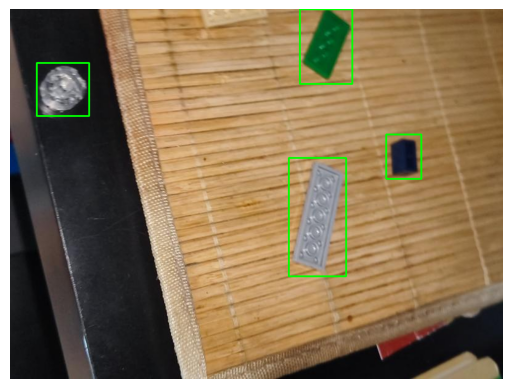

[INFO] EXIF metadata saved successfully.
[debug] Metadata saved to image: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw\image_1826.jpg
{
    "image_name": "image_1826.jpg",
    "inference_mode": "BricksOnly",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T20:20:03.001469",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_bricks_detected": 4
}
Prediction completed.


In [107]:
from random import randint
import os

# Load YOLO models
model_bricks = YOLO(r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\models\checkpoints\Brick_Model_best20250123_192838t.pt")  # Replace with your model path
model_studs = YOLO(r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\models\checkpoints\Stud_Model_best20250124_170824.pt" )    # Replace with your model path
# Define paths
#random interger from 0 to 1900
images_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw" 
images_folder_files = os.listdir(images_folder)
image_path_bricks = os.path.join(images_folder, images_folder_files[randint(0, len(images_folder_files)-1)])  # Random selection
working_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test"  # Folder for results


# Test 1: Run BricksOnly mode
predict_brick_dimensions(image_path_bricks, model_bricks, model_studs, mode="BricksOnly",
                         working_folder=working_folder, SAVE_ANNOTATED=True, PLT_ANNOTATED=True, SAVE_JSON=True)



0: 512x640 2 studs, 136.1ms
Speed: 4.0ms preprocess, 136.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


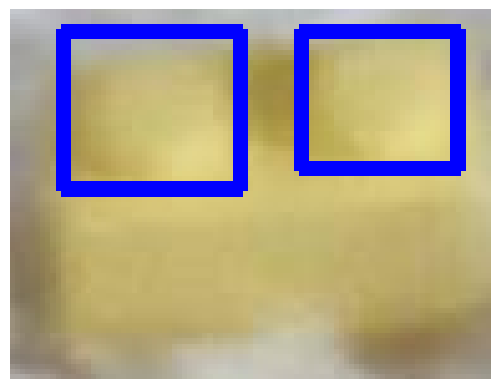

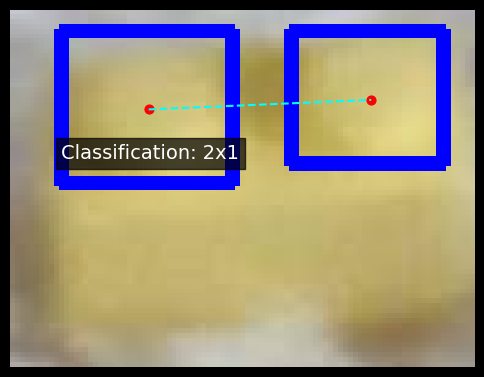

[INFO] EXIF metadata saved successfully.
[debug] Metadata saved to image: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks\image_125_LegoBrick_0_c82.jpg
{
    "image_name": "image_125_LegoBrick_0_c82.jpg",
    "inference_mode": "StudsOnly",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T20:20:07.274877",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_studs_detected": 2,
    "classification_result": "2x1"
}
Prediction completed.


In [108]:


Crop_bricks_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\processed\Cropped_bricks"
crop_bricks_files = os.listdir(Crop_bricks_folder)
image_path_studs =  os.path.join(Crop_bricks_folder, crop_bricks_files[randint(0, len(crop_bricks_files)-1)])  # Random selection


# Test 2: Run StudsOnly mode
predict_brick_dimensions(image_path_studs, model_bricks, model_studs, mode="StudsOnly",
                         working_folder=working_folder, SAVE_ANNOTATED=True, PLT_ANNOTATED=True, SAVE_JSON=True)



In [100]:
images_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw" 
images_folder_files = os.listdir(images_folder)
image_path_bricks = os.path.join(images_folder, images_folder_files[randint(0, len(images_folder_files)-1)])  # Random selection





0: 480x640 5 bricks, 108.9ms
Speed: 2.2ms preprocess, 108.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


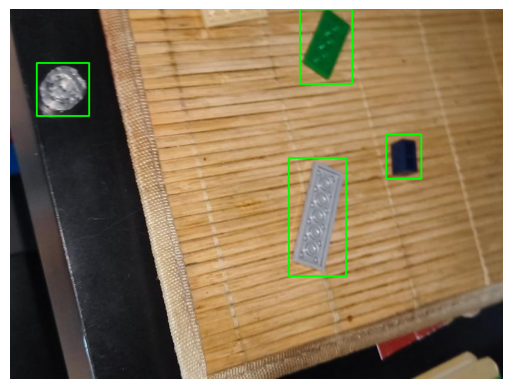


0: 480x640 1 stud, 211.5ms
Speed: 5.0ms preprocess, 211.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


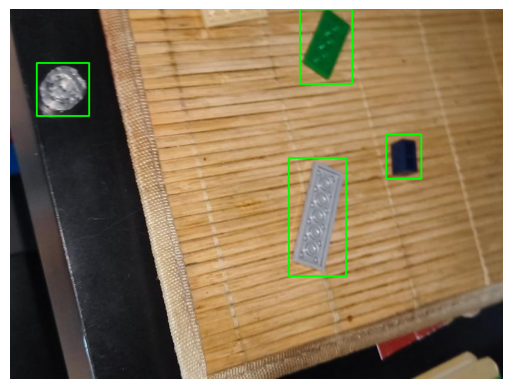

[INFO] No studs detected. Returning 'Unknown'.

0: 640x480 (no detections), 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


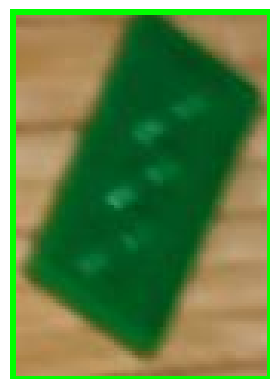

[INFO] No studs detected. Returning 'Unknown'.

0: 640x320 5 studs, 102.2ms
Speed: 2.0ms preprocess, 102.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 320)


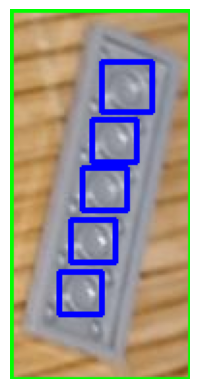

[ERROR] Deviant number of studs detected (5). Returning 'Error'.

0: 640x640 1 stud, 240.8ms
Speed: 5.0ms preprocess, 240.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


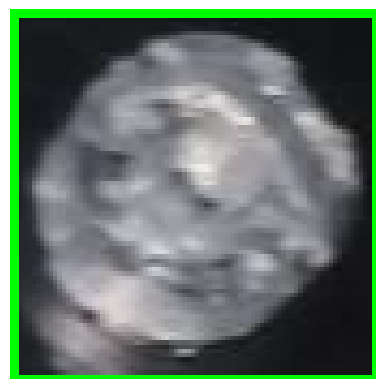

[INFO] No studs detected. Returning 'Unknown'.

0: 640x512 (no detections), 232.0ms
Speed: 5.0ms preprocess, 232.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


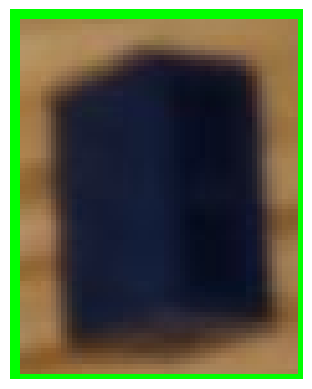

[INFO] No studs detected. Returning 'Unknown'.
[INFO] EXIF metadata saved successfully.
[debug] Metadata saved to image: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw\image_1826.jpg
{
    "image_name": "image_1826.jpg",
    "inference_mode": "BricksAndStuds",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T20:20:14.225896",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_bricks_detected": 4,
    "total_studs_detected": 0,
    "classification_result": "Unknown",


In [109]:

# Test 3: Run BricksAndStuds mode
predict_brick_dimensions(image_path_bricks, model_bricks, model_studs, mode="BricksAndStuds",
                         working_folder=working_folder, SAVE_ANNOTATED=True, PLT_ANNOTATED=True, SAVE_JSON=False)


In [110]:

# Test 4: Retrieve EXIF Metadata
metadata_exists, retrieved_metadata = retrieve_exif_metadata(image_path_bricks, CLEAN_IF_TRUE=False)
print("Metadata Exists:", metadata_exists)
if metadata_exists:
    print(retrieved_metadata)


{
    "image_name": "image_1826.jpg",
    "inference_mode": "BricksAndStuds",
    "model_bricks_hash": "1853d5efbbacec4b6058761c5368483971a0fd01dd25205521c5620c111cdbee",
    "model_studs_hash": "2f37a4bc5c5be3677683c036d1b9b2e914225840b453fdf260ff673b8696477d",
    "inference_datetime": "2025-01-28T20:20:14.225896",
    "script_execution_path": "c:\\ProgramData\\anaconda3\\envs\\MiguelEnv310\\lib\\site-packages\\ipykernel_launcher.py",
    "working_directory": "c:\\Users\\User\\Projects_Unprotected\\LEGO_Bricks_ML_Vision\\notebooks",
    "python_version": "3.10.16",
    "os_info": "Windows-10-10.0.22621-SP0",
    "hardware_info": "Intel64 Family 6 Model 142 Stepping 11, GenuineIntel",
    "total_bricks_detected": 4,
    "total_studs_detected": 0,
    "classification_result": "Unknown",
    "bricks_analysis": [
        {
            "brick_bbox": [
                470.1982116699219,
                0.06631851196289062,
                555.0481567382812,
                121.458511352539

In [4]:
# import os
# import multiprocessing

# num_threads = max(1, multiprocessing.cpu_count() // 2)  # Use half of available cores

# os.environ["OMP_NUM_THREADS"] = str(num_threads)
# os.environ["MKL_NUM_THREADS"] = str(num_threads)
# os.environ["OPENBLAS_NUM_THREADS"] = str(num_threads)
# os.environ["NUMEXPR_NUM_THREADS"] = str(num_threads)

# print(f"Optimized threading: Using {num_threads} threads")


Optimized threading: Using 4 threads


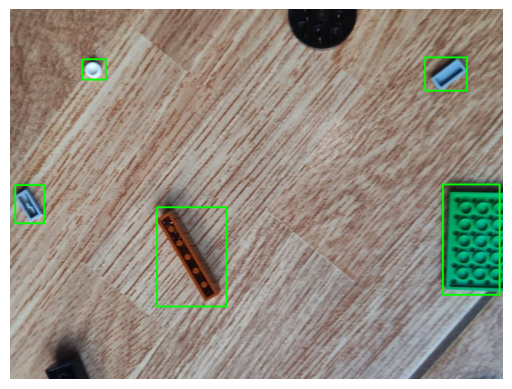

Processing completed.
Processing completed.


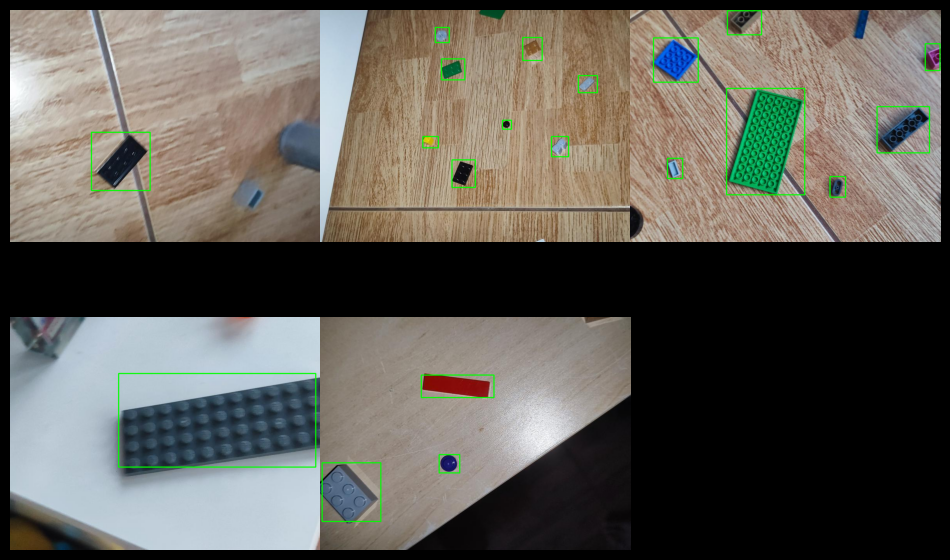

Processing completed.


In [30]:
import os
from random import randint

# Define paths
images_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\raw"  # Change this to the folder containing your images
labels_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\LabelMe_txt_bricks"  # Change this to the folder containing your YOLO .txt annotation files
output_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test"  # Used in Mode 2 and Mode 4

# # Test Mode 1: Display a single image with annotations
image_path = os.path.join(images_folder, f"image_{str(randint(0, 1900))}.jpg")  # Replace with an actual image name

visualize_yolo_annotations(image_path, labels_folder, mode=1)

# Test Mode 2: Save a single image with annotations
visualize_yolo_annotations(image_path, labels_folder, mode=2, extra_param=output_folder)

# Test Mode 3: Display a grid of random images with annotations (default: 6 images)
visualize_yolo_annotations(images_folder, labels_folder, mode=3, extra_param=5)

# Test Mode 4: Save all images in a folder with annotations
# visualize_yolo_annotations(images_folder, labels_folder, mode=4, extra_param=output_folder)


In [8]:

input_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\input test"
output_folder = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test"
# labelme_to_yolo(input_folder, output_folder)

# convert_keypoints_json(input_folder, output_folder)
labelme_to_yolo(output_folder, output_folder)

Conversion completed. YOLO .txt files saved to: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\data\annotations\export test


# cli.py

In [ ]:
import argparse
import sys
import logging
import os
import yaml
import glob
import time
import shutil

# Ensure Python can find the scripts folder
sys.path.append("scripts")

from scripts.pipeline_setup import setup_environment, verify_dataset_structure, create_preprocessing_structure, copy_and_partition_data, augment_data, copy_augmented_to_train, create_dataset_yaml, validate_final_structure
from scripts.pipeline_train import train_model, pre_training_cleanup, get_device
from scripts.pipeline_utils import labelme_to_yolo, convert_keypoints_json, visualize_yolo_annotations, run_inference



# Configure logging
log_filename = "cli_execution.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler(sys.stdout)
    ]
)
logging.info(f"[INFO] CLI execution started. Logs will be saved in {log_filename}.")

def get_latest_training_session(output_dir="regular_yolo_training"):
    """Finds the most recent training session inside regular_yolo_training/."""
    session_folders = sorted(glob.glob(os.path.join(output_dir, "*")), reverse=True)
    return session_folders[0] if session_folders else None

def run_setup(args):
    """Handles dataset setup with custom user parameters."""
    
    start_time = time.time()
    logging.info("[INFO] Starting dataset setup...")
    paths = setup_environment(dataset_name=args.dataset)
    logging.info("[INFO] Environment setup completed. Paths:")
    logging.info(paths)

    if args.verify_only:
        logging.info("[INFO] Verifying dataset structure...")
        verify_dataset_structure(paths["raw_images_path"], paths["raw_labels_path"])
        logging.info("[INFO] Dataset verification complete. No modifications were made.")
        return

    create_preprocessing_structure(paths["output_path"])

    if args.split:
        train_ratio, val_ratio, test_ratio = args.split
        if abs((train_ratio + val_ratio + test_ratio) - 1.0) > 1e-6:
            raise ValueError("[ERROR] Split ratios must sum to 1.0")
    else:
        train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

    copy_and_partition_data(paths["raw_images_path"], paths["raw_labels_path"], paths["output_path"],
                            train_ratio, val_ratio, test_ratio)

    if not args.no_augment:
        logging.info("[INFO] Applying data augmentation...")
        augment_data(
            input_images=os.path.join(paths["output_path"], "dataset/images/train"),
            input_labels=os.path.join(paths["output_path"], "dataset/labels/train"),
            output_dir=os.path.join(paths["output_path"], "augmented_dataset"),
            num_augmentations=args.augment
        )
        copy_augmented_to_train(
            augmented_dir=os.path.join(paths["output_path"], "augmented_dataset"),
            output_path=paths["output_path"]
        )
    else:
        logging.info("[INFO] Data augmentation skipped.")

    create_dataset_yaml(
        output_path=os.path.join(paths["output_path"], "dataset"),
        num_classes=1,
        class_names=["brick"]
    )

    validate_final_structure(paths["output_path"])
    logging.info("\n[INFO] Dataset setup complete. Ready for training.\n")
    end_time = time.time()
    logging.info(f"[INFO] Execution completed in {end_time - start_time:.2f} seconds.")

def run_train(args):
    """Handles model training with user-defined parameters."""
    
    start_time = time.time()
    dataset_yaml_path = "working/output/dataset/dataset.yaml"

    if not os.path.exists(dataset_yaml_path):
        logging.error("[ERROR] dataset.yaml not found! Run 'cli.py run-setup' first.")
        return

    # Cleanup old training results before starting
    pre_training_cleanup()

    with open(dataset_yaml_path, "r") as f:
        dataset_info = yaml.safe_load(f)
    
    dataset_name = dataset_info.get("names", {}).get(0, "Unknown Dataset")
    logging.info(f"[INFO] Training on dataset: {dataset_name}")
    
    model_path = args.resume if args.resume else args.model

    # Detect and log the device
    device = args.device if args.device else get_device()
    logging.info(f"[INFO] Using device: {device}")

    logging.info(f"[INFO] Training Parameters:")
    logging.info(f" - Model: {model_path}")
    logging.info(f" - Epochs: {args.epochs}")
    logging.info(f" - Batch Size: {args.batch_size}")
    logging.info(f" - Learning Rate: {args.learning_rate}")
    logging.info(f" - Momentum: {args.momentum}")
    logging.info(f" - Image Size: {args.imgsz}")

    train_model(
        dataset_yaml=dataset_yaml_path,
        pretrained_model=model_path,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.learning_rate,
        momentum=args.momentum,
        imgsz=args.imgsz,
        device=device
    )

    latest_session = get_latest_training_session()
    if latest_session:
        weights_path = os.path.join(latest_session, "train/weights/")
        results_path = os.path.join(latest_session, "train/results.png")
        
        logging.info("\n[INFO] Training complete!")
        logging.info(f"[INFO] Model weights saved at: {weights_path}")
        logging.info(f"[INFO] Summary results available at: {results_path}")
    else:
        logging.warning("[WARNING] Could not locate training session folder. Check manually.")
    
    end_time = time.time()
    logging.info(f"[INFO] Execution completed in {end_time - start_time:.2f} seconds.")

def run_utils(args):
    """Handles utility functions."""
    
    start_time = time.time()
    if args.convert_labels:
        if not args.input_folder or not args.output_folder:
            logging.error("[ERROR] Input and output folders are required for label conversion.")
            return
        logging.info(f"[INFO] Converting labels from {args.input_folder} to {args.output_folder}")
        labelme_to_yolo(args.input_folder, args.output_folder)

    elif args.convert_keypoints:
        if not args.input_folder or not args.output_folder:
            logging.error("[ERROR] Input and output folders are required for keypoint conversion.")
            return
        logging.info(f"[INFO] Converting keypoints from {args.input_folder} to {args.output_folder}")
        convert_keypoints_json(args.input_folder, args.output_folder)

    elif args.visualize_annotations:
        if not args.input_folder or not args.output_folder:
            logging.error("[ERROR] Input folder and output folder are required for annotation visualization.")
            return
        logging.info(f"[INFO] Visualizing annotations from {args.input_folder}")
        visualize_yolo_annotations(args.input_folder, args.output_folder, args.mode)

    elif args.infer:
        if not args.input_folder or not args.output_folder or not args.model:
            logging.error("[ERROR] Model, input, and output folders are required for inference.")
            return
        logging.info(f"[INFO] Running inference using {args.model} on {args.input_folder}")
        run_inference(args.model, args.input_folder, args.output_folder)
import shutil

def run_export_results(args):
    """Finds and exports the latest training results as a .zip file."""
    
    export_dir = "/app/data/exports/"
    
    if not os.path.exists(export_dir) or not os.listdir(export_dir):
        logging.error("[ERROR] No training results found in the export directory.")
        return
    
    # Find the latest zip archive
    zip_files = sorted(glob.glob(os.path.join(export_dir, "*.zip")), reverse=True)
    latest_zip = zip_files[0] if zip_files else None
    
    if not latest_zip:
        logging.error("[ERROR] No zip archives found in the export directory.")
        return
    
    logging.info(f"[INFO] Latest training archive found: {latest_zip}")

    # Copy the archive to user-specified location or provide Docker instructions
    if args.output:
        os.makedirs(args.output, exist_ok=True)
        shutil.copy(latest_zip, args.output)
        logging.info(f"[INFO] Archive copied to: {args.output}")
    else:
        logging.info("[INFO] To retrieve the file in Docker, use:")
        logging.info(f"docker cp <container_id>:{latest_zip} <destination_path>")


def main():
    parser = argparse.ArgumentParser(description="LEGO Bricks ML CLI")
    parser.add_argument("--version", action="store_true", help="Display CLI version.")
    
    subparsers = parser.add_subparsers(dest="command", help="Available subcommands")

    # Train command (define before usage)
    train_parser = subparsers.add_parser("run-train", help="Train the YOLO model")
    train_parser.add_argument("--epochs", type=int, default=50,
                            help="Number of training epochs (default: 50)")
    train_parser.add_argument("--batch-size", type=int, default=16,
                            help="Batch size (default: 16)")
    train_parser.add_argument("--learning-rate", type=float, default=0.001,
                            help="Initial learning rate (default: 0.001)")
    train_parser.add_argument("--momentum", type=float, default=0.9,
                            help="Momentum for optimizer (default: 0.9)")
    train_parser.add_argument("--imgsz", type=int, default=640,
                            help="Image size for YOLO training (default: 640)")
    train_parser.add_argument("--model", type=str, default="yolov8n.pt",
                            help="Path to the pre-trained YOLO model (default: yolov8n.pt)")
    train_parser.add_argument("--resume", type=str, help="Resume training from a checkpoint")
    train_parser.add_argument("--device", type=str, choices=["cpu", "cuda"],
                            help="Specify device for training ('cpu' or 'cuda'). If not set, auto-detect.")
    train_parser.set_defaults(func=run_train)

    # Export command (comes after train_parser is defined)
    export_parser = subparsers.add_parser("export-results", help="Export latest training results as a .zip file")
    export_parser.add_argument("--output", type=str, help="Specify a destination folder to copy the exported results.")
    export_parser.set_defaults(func=run_export_results)

    # Utilities command
    utils_parser = subparsers.add_parser("run-utils", help="Execute utility functions")

    export_parser = subparsers.add_parser("export-results", help="Export latest training results as a .zip file")
    export_parser.add_argument("--output", type=str, help="Specify a destination folder to copy the exported results.")
    export_parser.set_defaults(func=run_export_results)

    utils_parser.add_argument("--convert-labels", action="store_true",
                              help="Convert LabelMe JSON to YOLO format")
    utils_parser.add_argument("--convert-keypoints", action="store_true",
                              help="Convert keypoint JSON annotations to YOLO format")
    utils_parser.add_argument("--visualize-annotations", action="store_true",
                              help="Visualize YOLO annotations on images")
    utils_parser.add_argument("--infer", action="store_true",
                              help="Run YOLO model inference on a folder of images")
    
    utils_parser.add_argument("--input-folder", type=str, required=False,
                              help="Input folder path")
    utils_parser.add_argument("--output-folder", type=str, required=False,
                              help="Output folder path")
    utils_parser.add_argument("--model", type=str, required=False,
                              help="Path to trained YOLO model (required for inference)")
    utils_parser.add_argument("--mode", type=int, default=1,
                              help="Mode for visualization: (1=Single image, 2=Save single, 3=Grid, 4=Save all)")
    utils_parser.add_argument("--dry-run", action="store_true",
                              help="Preview what the command will do without executing it.")
    train_parser.add_argument("--device", type=str, choices=["cpu", "cuda"],
                              help="Specify device for training ('cpu' or 'cuda'). If not set, auto-detect.")

    
    utils_parser.set_defaults(func=run_utils)

    # Parse Arguments
    args = parser.parse_args()

    # Detect and log the training device
    device = args.device if args.device else get_device()
    logging.info(f"[INFO] Using device: {device}")
    
    if args.version:
        print("LEGO Bricks ML CLI v1.0.0")
        return
    
    if hasattr(args, "func"):
        if args.dry_run:
            logging.info("[DRY-RUN] This is a test run. No changes will be made.")
        else:
            args.func(args)
    else:
        parser.print_help()

if __name__ == "__main__":
    main()


# streamlit_dashboard.py

In [ ]:
# import streamlit as st
# import os
# import glob
# from PIL import Image

# def get_latest_training_session(output_dir="regular_yolo_training"):
#     """Finds the most recent training session inside regular_yolo_training/."""
#     session_folders = sorted(glob.glob(os.path.join(output_dir, "*")), reverse=True)
#     return session_folders[0] if session_folders else None

# def main():
#     st.title("LEGO Bricks Training Dashboard")

#     latest_session = get_latest_training_session()
#     if not latest_session:
#         st.error("No training sessions found. Run `cli.py run-train` first.")
#         return

#     st.sidebar.header("Session Details")
#     st.sidebar.write(f"📂 **Session Folder:** `{latest_session}`")
    
#     # Display Summary Image
#     results_path = os.path.join(latest_session, "results.png")
#     if os.path.exists(results_path):
#         st.image(Image.open(results_path), caption="Training Summary", use_column_width=True)
    
#     # Show Training Curves
#     for metric in ["confusion_matrix.png", "PR_curve.png", "F1_curve.png"]:
#         metric_path = os.path.join(latest_session, metric)
#         if os.path.exists(metric_path):
#             st.image(Image.open(metric_path), caption=metric.replace(".png", "").replace("_", " ").title(), use_column_width=True)

#     # Provide Download Links for Weights
#     weights_folder = os.path.join(latest_session, "weights")
#     if os.path.exists(weights_folder):
#         st.sidebar.header("Model Weights")
#         for weight_file in sorted(os.listdir(weights_folder)):
#             weight_path = os.path.join(weights_folder, weight_file)
#             st.sidebar.download_button(label=f"Download {weight_file}", data=open(weight_path, "rb"), file_name=weight_file)

#     st.success("Training results loaded successfully!")

# if __name__ == "__main__":
#     main()


notebook frienly

In [3]:
# import streamlit as st
# import os
# import glob
# from PIL import Image

# def get_latest_training_session(output_dir="regular_yolo_training"):
#     """Finds the most recent training session inside regular_yolo_training/."""
#     session_folders = sorted(glob.glob(os.path.join(output_dir, "*")), reverse=True)
#     return session_folders[0] if session_folders else None

# def run_dashboard(session_folder=None):
#     """ Launches the Streamlit dashboard for a specific session folder or the latest one. """
#     if session_folder is None:
#         session_folder = get_latest_training_session()
    
#     if not session_folder or not os.path.exists(session_folder):
#         st.error("No valid training session found. Provide a valid session folder or run a training session first.")
#         return

#     st.title("LEGO Bricks Training Dashboard")

#     st.sidebar.header("Session Details")
#     st.sidebar.write(f"📂 **Session Folder:** `{session_folder}`")
    
#     # Display Summary Image
#     results_path = os.path.join(session_folder, "train/results.png")
#     if os.path.exists(results_path):
#         st.image(Image.open(results_path), caption="Training Summary", use_column_width=True)
    
#     # Show Training Curves
#     for metric in ["confusion_matrix.png", "PR_curve.png", "F1_curve.png"]:
#         metric_path = os.path.join(session_folder, f"train/{metric}")
#         if os.path.exists(metric_path):
#             st.image(Image.open(metric_path), caption=metric.replace(".png", "").replace("_", " ").title(), use_column_width=True)

#     # Provide Download Links for Weights
#     weights_folder = os.path.join(session_folder, "train/weights")
#     if os.path.exists(weights_folder):
#         st.sidebar.header("Model Weights")
#         for weight_file in sorted(os.listdir(weights_folder)):
#             weight_path = os.path.join(weights_folder, weight_file)
#             st.sidebar.download_button(label=f"Download {weight_file}", data=open(weight_path, "rb"), file_name=weight_file)

#     st.success("Training results loaded successfully!")

# import subprocess

# def launch_dashboard(session_folder=None):
#     """ Run Streamlit dashboard for a specific training session. """
#     env = os.environ.copy()
#     if session_folder:
#         env["TRAIN_SESSION_FOLDER"] = session_folder  # Pass session path as env var
#     subprocess.run(["streamlit", "run", "scripts/streamlit_dashboard.py"], env=env)


# if __name__ == "__main__":
#     run_dashboard()


2025-01-30 07:31:20.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-30 07:31:20.444 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [4]:
train_info_folder_path= r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\results\TrainingSessions\20250123_192838bricks"

# launch_dashboard(train_info_folder_path)

# AFTER THAT

# Probar setup py

# NEW DIRECTION: 2 Dockers (TRAIN & UTILS)

## pipeline_train_docker.py

In [ ]:
import os
import shutil
import json
import yaml
import logging
import cv2
import optuna
import torch
from datetime import datetime
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from tqdm import tqdm
import albumentations as A
import argparse


# === Global Configurations ===
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "/app/data/output")
TRAINING_DIR = os.getenv("TRAINING_DIR", "/mnt/training")
DATASET_PATH = os.getenv("DATASET_PATH", "/app/data/datasets")
EPOCHS = int(os.getenv("EPOCHS", 50))
BATCH_SIZE = int(os.getenv("BATCH_SIZE", 16))

# === Logging Configuration ===
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def detect_cuda_device():
    """
    Detects available CUDA devices and selects the best one.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        logging.info(f"[INFO] CUDA available! {torch.cuda.device_count()} GPUs detected.")
        for i in range(torch.cuda.device_count()):
            logging.info(f" - GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        logging.info("[INFO] No GPU detected, running on CPU.")
    return device

def setup_dataset(custom_images=None, custom_labels=None):
    """
    Ensures the dataset is available inside the container. Uses custom dataset if provided.
    """
    if custom_images and custom_labels:
        logging.info("[INFO] Using custom dataset provided by the user.")
        dataset_yaml = os.path.join(OUTPUT_DIR, "custom_dataset.yaml")
        create_custom_dataset_yaml(custom_images, custom_labels, dataset_yaml)
    else:
        logging.info("[INFO] Checking default dataset availability...")
        datasets = {
            "bricks": "migueldilalla/spiled-lego-bricks",
            "studs": "migueldilalla/labeledstuds-lego-bricks"
        }
        for dataset_name, kaggle_path in datasets.items():
            dataset_dir = os.path.join(DATASET_PATH, dataset_name)
            if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
                logging.info(f"[INFO] Downloading dataset: {dataset_name} from Kaggle...")
                subprocess.run(["kaggle", "datasets", "download", "-d", kaggle_path, "-p", DATASET_PATH, "--unzip"], check=True)
            else:
                logging.info(f"[INFO] Dataset {dataset_name} is already available.")

def setup_pretrained_models(model_path=None, kaggle_model=None):
    """
    Fetches the YOLO model from Kaggle or uses a specified model path.
    """
    if model_path:
        logging.info(f"[INFO] Using custom model provided: {model_path}")
        return model_path
    
    models = {
        "bricks": "migueldilalla/lego_bricks_machinevisonyolofinetune",
        "studs": "migueldilalla/lego_brickstuds_machinevisionyolofinetune"
    }
    os.makedirs(TRAINING_DIR, exist_ok=True)
    
    if kaggle_model and kaggle_model in models:
        model_path = os.path.join(TRAINING_DIR, f"{kaggle_model}.pt")
        if not os.path.exists(model_path):
            logging.info(f"[INFO] Downloading {kaggle_model} model from Kaggle...")
            subprocess.run(["kaggle", "models", "download", "-m", models[kaggle_model], "-p", TRAINING_DIR, "--unzip"], check=True)
        return model_path
    
    return "yolov8n.pt"  # Default model

def train_model(model_path, dataset_yaml):
    """
    Trains the YOLO model.
    """
    logging.info("[INFO] Starting model training...")
    
    if not os.path.exists(dataset_yaml):
        logging.error("[ERROR] dataset.yaml not found. Run dataset setup first.")
        return
    
    model = YOLO(model_path)
    output_dir = os.path.join(TRAINING_DIR, datetime.now().strftime('%Y%m%d_%H%M%S'))
    os.makedirs(output_dir, exist_ok=True)
    
    device = detect_cuda_device()
    
    try:
        model.train(
            data=dataset_yaml,
            epochs=EPOCHS,
            batch=BATCH_SIZE,
            imgsz=640,
            lr0=0.001,
            momentum=0.9,
            project=output_dir,
            name="train",
            device=device
        )
        logging.info(f"[INFO] Training completed. Results saved in {output_dir}.")
    except Exception as e:
        logging.error(f"[ERROR] Training error: {e}")

def create_custom_dataset_yaml(images_path, labels_path, yaml_path):
    """
    Creates a dataset.yaml file for custom datasets.
    """
    dataset_config = {
        "train": images_path,
        "val": images_path,
        "nc": 1,
        "names": ["custom"]
    }
    with open(yaml_path, "w") as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    logging.info(f"[INFO] Custom dataset.yaml created at {yaml_path}")

def main():
    parser = argparse.ArgumentParser(description="Train a YOLO model with optional custom datasets and models.")
    parser.add_argument("--custom-images", type=str, help="Path to custom training images")
    parser.add_argument("--custom-labels", type=str, help="Path to custom YOLO labels")
    parser.add_argument("--model-path", type=str, help="Path to a custom YOLO model")
    parser.add_argument("--kaggle-model", type=str, choices=["bricks", "studs"], help="Choose a Kaggle pretrained model")
    args = parser.parse_args()
    
    setup_dataset(args.custom_images, args.custom_labels)
    model_path = setup_pretrained_models(args.model_path, args.kaggle_model)
    dataset_yaml = os.path.join(OUTPUT_DIR, "custom_dataset.yaml") if args.custom_images else os.path.join(OUTPUT_DIR, "dataset", "dataset.yaml")
    train_model(model_path, dataset_yaml)
    logging.info("[INFO] Pipeline execution completed successfully.")

if __name__ == "__main__":
    main()



# train_cli.py

In [ ]:
import argparse
import subprocess
import logging
import os

# === Logging Configuration ===
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def main():
    parser = argparse.ArgumentParser(description="CLI for training YOLO model inside Docker")
    
    # Training parameters
    parser.add_argument("--custom-images", type=str, help="Path to custom training images")
    parser.add_argument("--custom-labels", type=str, help="Path to custom YOLO labels")
    parser.add_argument("--model-path", type=str, help="Path to a custom YOLO model")
    parser.add_argument("--kaggle-model", type=str, choices=["bricks", "studs"], help="Choose a Kaggle pretrained model")
    
    args = parser.parse_args()
    
    # Construct command to execute pipeline_train_docker.py
    command = ["python", "pipeline_train_docker.py"]
    
    if args.custom_images:
        command.extend(["--custom-images", args.custom_images])
    if args.custom_labels:
        command.extend(["--custom-labels", args.custom_labels])
    if args.model_path:
        command.extend(["--model-path", args.model_path])
    if args.kaggle_model:
        command.extend(["--kaggle-model", args.kaggle_model])
    
    logging.info(f"[INFO] Executing command: {' '.join(command)}")
    subprocess.run(command, check=True)

if __name__ == "__main__":
    main()

# requeriments_train.txt

In [ ]:
# Machine Learning & Deep Learning
ultralytics==8.2.99

# Image Processing
opencv-python==4.9.0.80
pillow==11.1.0
matplotlib==3.8.4
albumentations==1.3.1

# Data Handling & Utilities
numpy==1.26.4
pandas==2.2.1
pyyaml==6.0.1
json5==0.9.14
glob2==0.7

# Machine Learning Optimization
optuna==3.5.0
scikit-learn==1.4.1

# CLI & Logging
argparse==1.4.0
tqdm==4.66.2
logging==0.4.9.6

# Kaggle API
kaggle==1.6.17

# Dockerfile.train

In [ ]:
FROM python:3.10-slim

# Set working directory
WORKDIR /app

# Install system dependencies
RUN apt update && apt install -y \
    git \
    unzip \
    && rm -rf /var/lib/apt/lists/*

# Copy requirements file
COPY requirements-train.txt ./requirements.txt

# Install Python dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Detect CUDA and install appropriate torch version
ARG TORCH_VERSION=2.4.1
RUN if python -c "import torch; print(torch.cuda.is_available())" | grep True; then \
        pip install torch==$TORCH_VERSION+cu118 --index-url https://download.pytorch.org/whl/cu118; \
    else \
        pip install torch==$TORCH_VERSION --index-url https://download.pytorch.org/whl/cpu; \
    fi


# Copy training scripts
COPY train_cli.py ./
COPY pipeline_train_docker.py ./

# Ensure proper execution permissions
RUN chmod +x train_cli.py

# Set entrypoint to the CLI
ENTRYPOINT ["python", "train_cli.py"]


# GenerateStructure.ps1

In [ ]:
# Path to the output file
$outputFile = "FolderStructure.txt"

# Initialize the output content
$output = [System.Collections.Generic.List[string]]::new()

# Function to recursively process the folder structure
function Get-FolderStructure {
    param (
        [string]$folderPath,   # The path of the current folder
        [int]$indentLevel      # Indentation level for readability
    )

    # Generate indentation
    $indent = " " * $indentLevel

    # Add the current folder to the output
    $output.Add("$indent- $(Split-Path $folderPath -Leaf)")

    # Get all files in the current folder
    $files = Get-ChildItem -Path $folderPath -File -ErrorAction SilentlyContinue

    if ($files.Count -gt 20) {
        # Summarize file types if there are more than 20 files
        $output.Add("$indent  More than 20 files, summary:")

        # Count files by extension
        $fileTypeCounts = @{}
        foreach ($file in $files) {
            $ext = $file.Extension.ToLower()
            if (-not $fileTypeCounts.ContainsKey($ext)) {
                $fileTypeCounts[$ext] = 0
            }
            $fileTypeCounts[$ext]++
        }

        # Add summary to the output
        foreach ($ext in $fileTypeCounts.Keys) {
            $output.Add("$indent    ${ext}: $($fileTypeCounts[$ext]) files")
        }
    } else {
        # List all files if there are 20 or fewer, including last modified time
        foreach ($file in $files) {
            $minutesAgo = [math]::Round((New-TimeSpan -Start $file.LastWriteTime -End (Get-Date)).TotalMinutes, 1)
            $output.Add("$indent  $($file.Name) (modified $minutesAgo minutes ago)")
        }
    }

    # Process subdirectories
    $subdirs = Get-ChildItem -Path $folderPath -Directory -ErrorAction SilentlyContinue
    foreach ($subdir in $subdirs) {
        Get-FolderStructure -folderPath $subdir.FullName -indentLevel ($indentLevel + 2)
    }
}

# Start processing from the current directory
Get-FolderStructure -folderPath (Get-Location).Path -indentLevel 0

# Save the output to a file
$output -join "`n" | Set-Content -Path $outputFile -Encoding UTF8

# Inform the user
Write-Output "Folder structure has been saved to '$outputFile'"
